# CytoData 2023 Hackathon

This is an example Notebook that presents how the hackathon data can be used.

In [1]:
# Import used libraries
import re
import imageio
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.metrics
import umap
import umap.plot
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

/home/user/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
imgpath = Path('images')
featurepath = Path('metadata/hackathon_features.csv')
metapath = Path('metadata/hackathon_metadata.csv')
channels = ['1_AF488', '1_AF555', '1_AF647', '1_AF750', '1_DAPI', '2_AF647']

## Helper functions

In [3]:
def crop_rgb_tiles(img, cshape):
    tiles = []
    for sx in range((img.shape[1]%cshape[1])//2, img.shape[1]-cshape[1], cshape[1]):
        for sy in range((img.shape[0]%cshape[0])//2, img.shape[0]-cshape[0], cshape[0]):
            cimg = img[sy:sy+cshape[0], sx:sx+cshape[1]]
            rgbimg = np.zeros((cshape[0],cshape[1],3), dtype=np.float32)
            rgbimg[:,:,0] = cimg
            rgbimg[:,:,1] = cimg
            rgbimg[:,:,2] = cimg
            tiles.append(rgbimg)
    return tiles

## Read and check metadata and features

In [4]:
df_metadata = pd.read_csv(metapath)
df_features = pd.read_csv(featurepath)

In [5]:
# Add Test information in the df_features
df_features = df_features.merge(df_metadata[['Slide','ROI number','Test','DSS_status']], on=['Slide','ROI number'], how='left')

In [6]:
# Check metadata
df_metadata

,Slide,ROI number,PatientID,Location,TimeToDeath_months,OS_status,DSS_status,TimeToRelapse_months,pT_simple,Fuhrman,Test
0,TMA_19-10,16,1,1,24.657507,1,1,12.295877,3,3,1
1,TMA_19-10,17,1,1,24.657507,1,1,12.295877,3,3,1
2,TMA_19-10,18,1,2,24.657507,1,1,12.295877,3,3,1
3,TMA_19-10,19,1,2,24.657507,1,1,12.295877,3,3,1
4,TMA_19-10,20,1,3,24.657507,1,1,12.295877,3,3,1
5,TMA_19-9,115,2,1,24.197234,1,1,10.158893,2,1,0
6,TMA_19-9,116,2,1,24.197234,1,1,10.158893,2,1,0
7,TMA_19-9,117,2,2,24.197234,1,1,10.158893,2,1,0
8,TMA_19-9,118,2,2,24.197234,1,1,10.158893,2,1,0
9,TMA_19-9,119,2,3,24.197234,1,1,10.158893,2,1,0


In [7]:
# Check features
df_features.head(n=10)

,Slide,ROI number,ImageNumber,ObjectNumber,Intensity_MaxIntensity_Dapi,Intensity_MaxIntensity_Epi,Intensity_MaxIntensity_Fap,Intensity_MaxIntensity_Pdgfra,Intensity_MaxIntensity_Pdgfrb,Intensity_MaxIntensity_Sma,...,Intensity_MedianIntensity_Pdgfrb,Intensity_MedianIntensity_Sma,Intensity_UpperQuartileIntensity_Dapi,Intensity_UpperQuartileIntensity_Epi,Intensity_UpperQuartileIntensity_Fap,Intensity_UpperQuartileIntensity_Pdgfra,Intensity_UpperQuartileIntensity_Pdgfrb,Intensity_UpperQuartileIntensity_Sma,Test,DSS_status
0,TMA_19-10,16,16,1,0.108080,1.0,0.063325,0.004501,0.104707,0.295918,...,0.043626,0.036713,0.078386,1.0,0.023468,0.003586,0.055985,0.089052,1,1
1,TMA_19-10,16,16,2,0.085634,0.0,0.106416,0.004929,0.080980,0.507790,...,0.031586,0.135882,0.062348,0.0,0.026612,0.003861,0.044388,0.240894,1,1
2,TMA_19-10,16,16,3,0.046082,1.0,0.025986,0.004761,0.012131,0.007095,...,0.004639,0.004028,0.031315,1.0,0.011673,0.003326,0.006802,0.004837,1,1
3,TMA_19-10,16,16,4,0.057023,1.0,0.032761,0.004730,0.039948,0.201816,...,0.005310,0.005325,0.039353,1.0,0.012634,0.003311,0.006382,0.008457,1,1
4,TMA_19-10,16,16,5,0.056199,1.0,0.134569,0.004791,0.045029,0.124743,...,0.016052,0.033249,0.043290,1.0,0.039155,0.003754,0.025696,0.063371,1,1
5,TMA_19-10,16,16,6,0.026001,1.0,0.032334,0.003922,0.011139,0.005402,...,0.004921,0.003861,0.019970,1.0,0.018189,0.003082,0.006226,0.004242,1,1
6,TMA_19-10,16,16,7,0.057481,1.0,0.079072,0.004486,0.027344,0.008316,...,0.005524,0.004547,0.041428,1.0,0.014954,0.003311,0.006470,0.005066,1,1
7,TMA_19-10,16,16,8,0.061143,0.0,0.178836,0.004761,0.111421,0.586099,...,0.035203,0.218448,0.045197,0.0,0.051499,0.003586,0.045151,0.332891,1,1
8,TMA_19-10,16,16,9,0.066377,0.0,0.023651,0.004700,0.077806,0.313695,...,0.012047,0.037339,0.050656,0.0,0.013607,0.003555,0.029358,0.088712,1,1
9,TMA_19-10,16,16,10,0.057588,1.0,0.011444,0.003418,0.006149,0.005692,...,0.003906,0.003555,0.036534,1.0,0.007202,0.002640,0.004303,0.004166,1,1


## Visualize images

Open a random core and visualize it.

In [8]:
idx = df_metadata.sample(n=1).index[0]
imgpaths = imgpath.glob(df_metadata.loc[idx,'Slide']+'*roi{:03d}*'.format(df_metadata.loc[idx,'ROI number']))
imgpaths = [x for x in imgpaths]
imgpaths.sort()

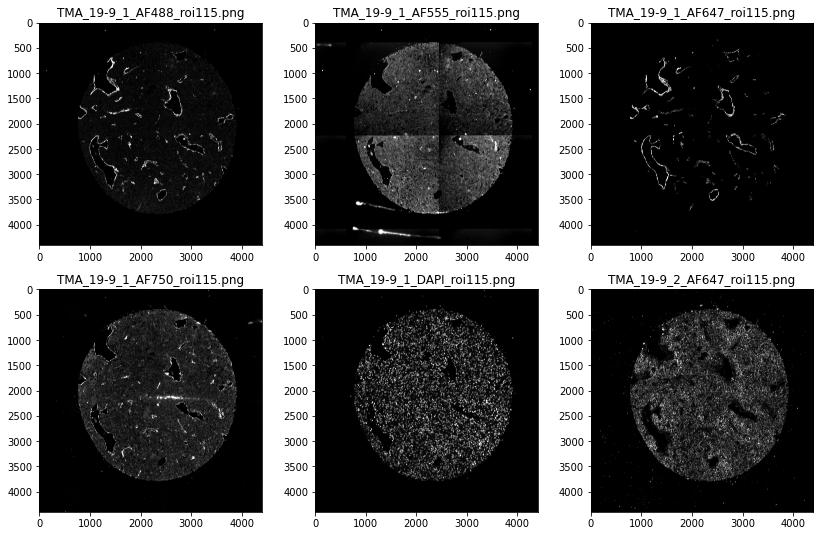

In [9]:
# There should be 6 images to view
rows = 2
cols = 3
fig,ax = plt.subplots(rows,cols,figsize=(14,9))
for i,ipath in enumerate(imgpaths):
    img = imageio.imread(ipath).astype(np.float32)
    # Scale images from median (bg) to 0.998 quantile for visualization
    intlow,inthigh = np.quantile(img,[0.5,0.998])
    img = (img - intlow) / (inthigh-intlow)
    img[img<0.0] = 0.0
    img[img>1.0] = 1.0
    img = (img * 255.0).astype(np.uint8)
    ax[i//cols, i%cols].imshow(img, cmap='gray')
    ax[i//cols, i%cols].set_title(ipath.name)

## Classical features

### Preprocess features

In [10]:
# Feature columns
featcols = [x for x in df_features.columns if 'Intensity' in x]

In [11]:
# drop NA
prep_features = df_features.dropna()

In [12]:
# Scale features
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(prep_features[featcols])
prep_features.loc[:,featcols] = scaler.transform(prep_features[featcols])
prep_features = prep_features.dropna()

/home/user/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [13]:
train_scfeat = prep_features[prep_features['Test']==0]
test_scfeat = prep_features[prep_features['Test']==1]

In [14]:
# Visualize single-cell features of the training data
mapper = umap.UMAP()
mapper.fit(train_scfeat[featcols])

/home/user/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)


UMAP(dens_frac=0.0, dens_lambda=0.0)

<AxesSubplot:>

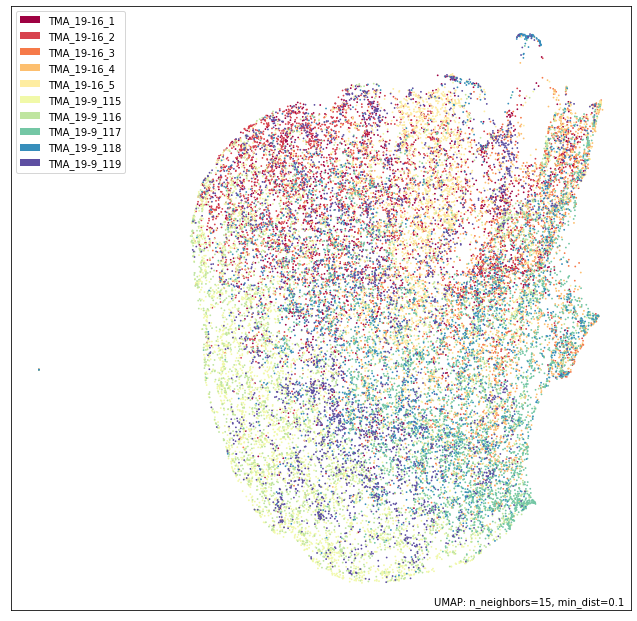

In [15]:
umap.plot.points(mapper, labels=train_scfeat['Slide']+'_'+train_scfeat['ROI number'].astype(str))

In [16]:
# Median features for each ROI
med_features = prep_features.groupby(['Slide','ROI number']).median().reset_index()

### Toy classification example

In [17]:
# Use single-cell features for classification
X_train = train_scfeat[featcols]
y_train = train_scfeat['DSS_status']
X_test = test_scfeat[featcols]
y_test = test_scfeat['DSS_status']

In [18]:
# Fit and predict
model = sklearn.ensemble.RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [19]:
# Evaluate
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
precision = sklearn.metrics.precision_score(y_test, y_pred)
recall = sklearn.metrics.recall_score(y_test, y_pred)

In [20]:
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.555
Precision: 0.573
Recall: 0.493


## DL features with pretrained network

In [21]:
input_shape = (256,256,3)
dl_featcols = ['feat_{}'.format(x) for x in range(2048)]

In [22]:
# Check channel distributions for preprocessing
ch_dist = {}
for ch in channels:
    files = imgpath.glob(f'*{ch}*')
    files = [x for x in files]
    dist = np.zeros((len(files),2), dtype=np.float32)
    for i,fpath in tqdm(enumerate(files)):
        img = imageio.imread(fpath)
        dist[i,0] = img.mean()
        dist[i,1] = img.std()
    ch_dist[ch] = (np.mean(dist[:,0]), np.mean(dist[:,1]))

20it [00:16,  1.19it/s]
20it [00:15,  1.32it/s]
20it [00:17,  1.14it/s]
20it [00:16,  1.20it/s]
20it [00:17,  1.17it/s]
20it [00:18,  1.08it/s]


In [23]:
ch_dist

{'1_AF488': (779.1337, 1583.8152),
 '1_AF555': (176.04375, 210.40103),
 '1_AF647': (745.7633, 2138.7563),
 '1_AF750': (397.76068, 473.80707),
 '1_DAPI': (1764.1891, 2446.5674),
 '2_AF647': (1397.8392, 2911.683)}

In [24]:
# Load pretrained model
resnet = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape, weights='imagenet', pooling='max')
resnet.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 128, 128, 64) 256         conv1[0][0]                      
_____________________________________

In [25]:
# Extract features separately for each image
df_dlrois = []
for idx,row in tqdm(df_metadata.iterrows()):
    ipaths = imgpath.glob(row['Slide']+'*roi{:03d}*'.format(row['ROI number']))
    pat = re.compile('{}_(\d_\w+)_roi{:03d}.png'.format(row['Slide'],row['ROI number']))
    df_dlchs = []
    for ipath in ipaths:
        ch = pat.match(ipath.name).group(1)
        img = imageio.imread(ipath).astype(np.float32)
        img = (img - ch_dist[ch][0]) / ch_dist[ch][1]
        tiles = crop_rgb_tiles(img, input_shape)
        feat = np.zeros((len(tiles),2048), dtype=np.float32)
        tiles = np.stack(tiles)
        feat = resnet.predict(tiles)
        df_dlroi = pd.DataFrame(columns=[ch+'_'+x for x in dl_featcols], data=feat)
        df_dlchs.append(df_dlroi)
    df_dlch = pd.concat(df_dlchs, axis=1)
    df_dlch['Slide'] = row['Slide']
    df_dlch['ROI number'] = row['ROI number']
    df_dlch['Test'] = row['Test']
    df_dlrois.append(df_dlch)
df_dlfeat = pd.concat(df_dlrois)

20it [03:33, 10.69s/it]


### Preprocess and visualize

In [26]:
dl_featcols = [x for x in df_dlfeat.columns if 'feat' in x]
df_dlfeat

,1_AF488_feat_0,1_AF488_feat_1,1_AF488_feat_2,1_AF488_feat_3,1_AF488_feat_4,1_AF488_feat_5,1_AF488_feat_6,1_AF488_feat_7,1_AF488_feat_8,1_AF488_feat_9,...,2_AF647_feat_2041,2_AF647_feat_2042,2_AF647_feat_2043,2_AF647_feat_2044,2_AF647_feat_2045,2_AF647_feat_2046,2_AF647_feat_2047,Slide,ROI number,Test
0,-1.562594,-0.770635,-0.141301,-1.467074,6.738761,-3.150799,-0.713227,4.680943,0.250866,-1.679202,...,0.082731,-1.455053,-2.065399,-1.421470,18.586273,-0.710119,-1.903876,TMA_19-10,16,1
1,-1.562505,-0.769704,-0.141817,-1.471241,6.739908,-3.150125,-0.713100,4.677241,0.252315,-1.676350,...,-1.289254,-0.670850,-0.991783,-1.571891,16.368591,0.446258,-1.915226,TMA_19-10,16,1
2,-1.562907,-0.770468,-0.140594,-1.469099,6.740194,-3.152195,-0.712701,4.678792,0.254593,-1.678589,...,2.144065,-0.630425,-1.894514,-1.361595,17.321228,0.249742,-1.729501,TMA_19-10,16,1
3,-1.562347,-0.658982,-0.139067,-1.466729,6.373925,-3.449152,-0.716437,4.476279,0.230467,-1.664192,...,-0.097073,-0.480528,-0.462925,-0.237788,18.765713,0.132208,-1.689659,TMA_19-10,16,1
4,-1.562586,-0.766674,-0.140774,-1.463882,6.730915,-3.150957,-0.711140,4.683670,0.255134,-1.679036,...,-1.163459,0.759625,-1.756080,-1.467022,9.493343,-0.747128,-1.960397,TMA_19-10,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,-1.563329,-0.767247,-0.142479,-1.472218,6.735613,-3.151764,-0.711217,4.683914,0.254371,-1.675615,...,-1.277965,1.099670,-1.621513,-1.326382,5.011660,-0.906683,-1.914327,TMA_19-18,135,1
252,-1.563539,-0.767438,-0.141670,-1.467548,6.733067,-3.152290,-0.711344,4.681994,0.253317,-1.682372,...,-1.273478,1.084841,-1.628461,-1.344698,5.009495,-0.857786,-1.934973,TMA_19-18,135,1
253,-1.563251,-0.767915,-0.140793,-1.476897,6.736901,-3.151892,-0.711627,4.683579,0.253375,-1.678942,...,-1.276420,1.083748,-1.617770,-1.327169,5.005376,-0.900433,-1.916332,TMA_19-18,135,1
254,-1.562416,-0.769850,-0.140017,-1.445085,6.732959,-3.142260,-0.711942,4.682693,0.237976,-1.682257,...,-1.274715,1.072016,-1.642444,-1.329840,5.028579,-0.893126,-1.907176,TMA_19-18,135,1


In [27]:
dlfeat = df_dlfeat.copy()
dlfeat = dlfeat.merge(df_metadata[['Slide','ROI number','DSS_status']], on=['Slide','ROI number'], how='left')
# Scale features
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(dlfeat[dl_featcols])
dlfeat.loc[:,dl_featcols] = scaler.transform(dlfeat[dl_featcols])
dlfeat = dlfeat.dropna()

In [28]:
train_scfeat = dlfeat[dlfeat['Test']==0]
test_scfeat = dlfeat[dlfeat['Test']==1]

In [29]:
# Visualize single-cell features of the training data
mapper = umap.UMAP()
mapper.fit(train_scfeat[dl_featcols])

UMAP(dens_frac=0.0, dens_lambda=0.0)

<AxesSubplot:>

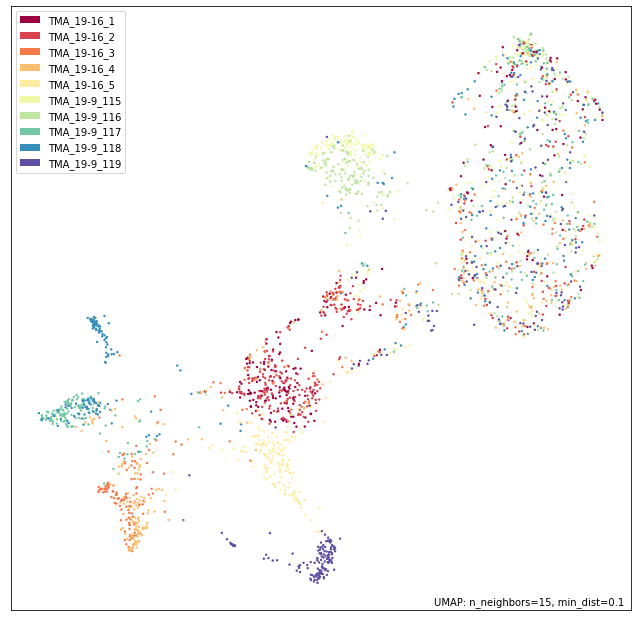

In [30]:
umap.plot.points(mapper, labels=train_scfeat['Slide']+'_'+train_scfeat['ROI number'].astype(str))

### Toy classification with DL features

In [31]:
# Use single-cell features for classification
X_train = train_scfeat[dl_featcols]
y_train = train_scfeat['DSS_status']
X_test = test_scfeat[dl_featcols]
y_test = test_scfeat['DSS_status']

In [32]:
# Fit and predict
model = sklearn.ensemble.RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [33]:
# Evaluate
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
precision = sklearn.metrics.precision_score(y_test, y_pred)
recall = sklearn.metrics.recall_score(y_test, y_pred)

In [34]:
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.567
Precision: 0.559
Recall: 0.634
